酒店个数: 152
第10个酒店
Soak up the vibrant scene in the Living Room Bar and get in the mix with our live music and DJ series before heading to a memorable dinner at TRACE. Offering inspired seasonal fare in an award-winning atmosphere, it's a not-to-be-missed culinary experience in downtown Seattle. Work it all off the next morning at FIT®, our state-of-the-art fitness center before wandering out to explore many of the area's nearby attractions, including Pike Place Market, Pioneer Square and the Seattle Art Museum. As always, we've got you covered during your time at W Seattle with our signature Whatever/Whenever® service - your wish is truly our command.
Name: W Seattle
None
----------------------------------------------------------------------------------------------------
第17个酒店
Treat yourself to a rewarding stay at the SpringHill Suites Seattle Downtown/South Lake Union. Our goal is to make you as comfortable as possible - whether you're in Seattle, Washington for a night, a weekend, or

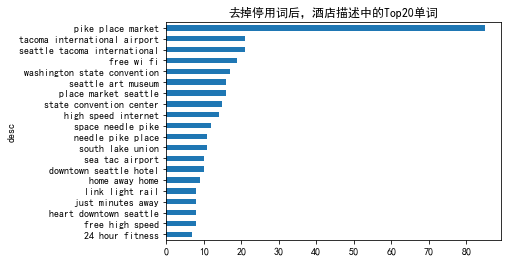

0    located southern tip lake union hilton garden ...
1    located citys vibrant core sheraton grand seat...
2    located heart downtown seattle awardwinning cr...
Name: desc_clean, dtype: object
IDF features names:
['000', '000 sq', '000 sq ft', '000 square', '000 square feet', '10', '100', '100 nonsmoking', '10minute', '11', '12', '120', '14', '15', '15 miles', '15 miles hotel', '15 minutes', '16', '17', '1900']
3154
----------------------------------------------------------------------------------------------------
tfidf_matrix:
(152, 3154)
[[1.         0.0391713  0.10519839 ... 0.04506191 0.01188579 0.02732358]
 [0.0391713  1.         0.06121291 ... 0.06131857 0.01508036 0.03706011]
 [0.10519839 0.06121291 1.         ... 0.09179925 0.04235642 0.05607314]
 ...
 [0.04506191 0.06131857 0.09179925 ... 1.         0.0579826  0.04145794]
 [0.01188579 0.01508036 0.04235642 ... 0.0579826  1.         0.0172546 ]
 [0.02732358 0.03706011 0.05607314 ... 0.04145794 0.0172546  1.        ]]
(152,

In [21]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import random
pd.options.display.max_columns = 30
import matplotlib.pyplot as plt

# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']
df = pd.read_csv('Seattle_Hotels.csv',encoding='latin-1')  
# Latin-1是8比特的字符集，定义了256个字符。前128个字符(00000000-01111111)与ASCII完全一致。
# 数据探索
print('酒店个数:',len(df))
# print(df.head())

def print_description(index):
    example = df[df.index==index][['desc','name']].values[0]
    if len(example)>0:
        print(example[0])
        print('Name:',example[1])
        
print('第10个酒店')
print(print_description(10))
print('-'*100)
print('第17个酒店')
print(print_description(17))
        
# 得到酒店描述中n-gram特征中的TopK个
def get_top_n_words(corpus,n=1,k=None):
    # 统计ngram词频矩阵,
    vec = CountVectorizer(ngram_range=(n,n),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    """
    print('feature names:')
    print(vec.get_feature_names())
    print('bag of words:')
    print(bag_of_words.toarray())
    """
    sum_words = bag_of_words.sum(axis=0) #计算词组出现的次数，行向量中的元素相加。
    print(sum_words[0:10])
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    # 按照词频从大到小排序
    words_freq = sorted(words_freq,key = lambda x : x[1],reverse=True)
    return words_freq[:k]

common_words = get_top_n_words(df['desc'],3,20)
# print(common_words)
df1 = pd.DataFrame(common_words,columns=['desc','count'])
df1.groupby(by='desc').sum()['count'].sort_values().plot(kind='barh',title='去掉停用词后，酒店描述中的Top20单词')
plt.show()


# 文本预处理
Replace_by_space_re = re.compile(r'[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile(r'[^0-9a-z +_#]')
STOPWORDS = set(stopwords.words('english'))    # set 集合

# 对文本进行清洗
def clean_text(text):
    #全部小写
    text = text.lower()
    #空格代替特殊符号
    text = Replace_by_space_re.sub(' ',text)
    # 移除BAD_SYMBOLS_RE
    text = BAD_SYMBOLS_RE.sub('',text)
    # 从文本中去掉停用词  
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
# 对desc字段进行清理
df['desc_clean'] = df['desc'].apply(clean_text)
print(df['desc_clean'][0:3])

# 建模
df.set_index('name',inplace=True)
# 使用TF-IDF提取文本特征
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.01, stop_words='english')
tfidf_matrix = tf.fit_transform(df['desc_clean'])
print('IDF features names:')
print(tf.get_feature_names()[0:20])
print(len(tf.get_feature_names()))
print('-'*100)
print('tfidf_matrix:')
#print(tfidf_matrix)
print(tfidf_matrix.shape)

# 计算酒店之间的余弦相似度（线性核函数）
cosine_similarities = linear_kernel(tfidf_matrix,tfidf_matrix)
print(cosine_similarities)
print(cosine_similarities.shape)
indices = pd.Series(df.index) #df.index为酒店名称
print('-'*100)
print(indices[0:10])

# 基于相似度矩阵和指定的酒店name，推荐TOP10酒店
def recommendations(hotel_name,cosine_similarities=cosine_similarities):
    recommend_hotels = []
    # 找到想要查询酒店名称的idx    
    idx = indices[indices==hotel_name].index[0]
    print('idx:',idx)
    # 对于idx酒店的余弦相似度向量按照从大到小进行排序
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=True)
    # 取相似度最大的前10个（除了自己以外）
    top10 = list(score_series.iloc[1:11].index)
    # 放到推荐列表中
    for i in top10:
        recommend_hotels.append(list(df.index)[i])
    return recommend_hotels

print(recommendations('Hilton Seattle Airport & Conference Center'))
print(recommendations('The Bacon Mansion Bed and Breakfast'))

In [5]:
df.head()

,name,address,desc
0,Hilton Garden Seattle Downtown,"1821 Boren Avenue, Seattle Washington 98101 USA","Located on the southern tip of Lake Union, the..."
1,Sheraton Grand Seattle,"1400 6th Avenue, Seattle, Washington 98101 USA","Located in the city's vibrant core, the Sherat..."
2,Crowne Plaza Seattle Downtown,"1113 6th Ave, Seattle, WA 98101","Located in the heart of downtown Seattle, the ..."
3,Kimpton Hotel Monaco Seattle,"1101 4th Ave, Seattle, WA98101",What?s near our hotel downtown Seattle locatio...
4,The Westin Seattle,"1900 5th Avenue, Seattle, Washington 98101 USA",Situated amid incredible shopping and iconic a...
